<a href="https://colab.research.google.com/github/yehezkielgunawan/thesis-risk-classification/blob/main/RF_Classification_Custom_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [36]:
!pip install scikit-learn
!pip install scikit-plot

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Load the new dataset for sentiment classification
new_data = pd.read_excel('/content/gdrive/My Drive/Tesis/Compiled Classification Dataset.xlsx')
sentences = new_data['content'].tolist()

# Load the exported word embeddings
embeddings = np.load('/content/gdrive/My Drive/Tesis/bert_embeddings.npy')

In [38]:
new_data.head(5)

,Unnamed: 0,content,priority_score,problem_domain
0,1,"Sorry, including the expensive price + apk usi...",2,0
1,2,Setelah install terus pas buka aplikasi ngebla...,3,1
2,3,"gak bisa submit pada saat verifikasi data, pad...",3,1
3,4,Aplilasi restart mulu,3,1
4,5,"udah mahal , makanan ga enak, banyak lalat",2,1


In [39]:
# Check the label distributions
priority_score_distribution = new_data['priority_score'].value_counts()
problem_domain_distribution = new_data['problem_domain'].value_counts()

print("Label priority_score Distribution:")
print(priority_score_distribution)

print("Label problem_domain Distribution:")
print(problem_domain_distribution)

Label priority_score Distribution:
3    277
2    275
1    148
Name: priority_score, dtype: int64
Label problem_domain Distribution:
0    569
1    131
Name: problem_domain, dtype: int64


In [40]:
# Assuming the labels for the new dataset are stored in two columns: 'label1' and 'label2'
priority_score = new_data['priority_score'][:len(embeddings)]
problem_domain = new_data['problem_domain'][:len(embeddings)]

# Truncate the embeddings to match the number of rows in new_data
embeddings = embeddings[:len(priority_score)]

# Define the class weights for label 1
# class_weights1 = {
#     1: 5,  # Class 1 weight
#     2: 1,  # Class 2 weight
#     3: 1   # Class 3 weight
# }

# Define the class weights for label 2
# class_weights2 = {
#     0: 1,  # Class 0 weight
#     1: 5   # Class 1 weight
# }

# Split the data into training and testing sets
X_train, X_test, y_train1, y_test1, y_train2, y_test2 = train_test_split(embeddings, priority_score, problem_domain, test_size=0.3, stratify=new_data['problem_domain'], random_state=42)

In [41]:
# Define the parameter grid for Grid Search for priority_score
param_grid1 = {
    'n_estimators': [25, 75, 150],
    'max_depth': [None, 5, 12],
    'min_samples_split': [5, 7, 10]
}

# Define the parameter grid for Grid Search for problem_domain
param_grid2 = {
    'n_estimators': [25, 75, 125],
    'max_depth': [None, 5, 12],
    'min_samples_split': [2, 5, 10]
}

# Initialize the Random Forest classifiers
rf_classifier1 = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_classifier2 = RandomForestClassifier(class_weight="balanced", random_state=42)

# Perform Grid Search to find the best hyperparameters for priority_score
grid_search1 = GridSearchCV(estimator=rf_classifier1, param_grid=param_grid1, cv=5)
grid_search1.fit(X_train, y_train1)

# Perform Grid Search to find the best hyperparameters for problem_domain
grid_search2 = GridSearchCV(estimator=rf_classifier2, param_grid=param_grid2, cv=5)
grid_search2.fit(X_train, y_train2)

# Get the best classifiers with the optimal hyperparameters
best_classifier1 = grid_search1.best_estimator_
best_classifier2 = grid_search2.best_estimator_

# Evaluate the best classifiers on the test sets for priority_score
y_pred1 = best_classifier1.predict(X_test)
classification_rep1 = classification_report(y_test1, y_pred1)

# Evaluate the best classifiers on the test sets for problem_domain
y_pred2 = best_classifier2.predict(X_test)
classification_rep2 = classification_report(y_test2, y_pred2)

print("Best Hyperparameters for priority_score:", grid_search1.best_params_)
print("Classification Report for priority_score:")
print(classification_rep1)

print("Best Hyperparameters for problem_domain:", grid_search2.best_params_)
print("Classification Report for problem_domain:")
print(classification_rep2)

Best Hyperparameters for priority_score: {'max_depth': 12, 'min_samples_split': 10, 'n_estimators': 75}
Classification Report for priority_score:
              precision    recall  f1-score   support

           1       0.33      0.02      0.03        57
           2       0.33      0.69      0.44        67
           3       0.37      0.29      0.33        86

    accuracy                           0.34       210
   macro avg       0.35      0.33      0.27       210
weighted avg       0.35      0.34      0.28       210

Best Hyperparameters for problem_domain: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 75}
Classification Report for problem_domain:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       171
           1       0.40      0.05      0.09        39

    accuracy                           0.81       210
   macro avg       0.61      0.52      0.49       210
weighted avg       0.74      0.81      0.74       210



In [42]:
# Function to plot confusion matrix
def plot_confusion_matrix_3x3(cm, title):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues', xticklabels=[1,2,3], yticklabels=[1,2,3])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def plot_confusion_matrix_2x2(cm, title):
    plt.figure(figsize=(2, 2))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

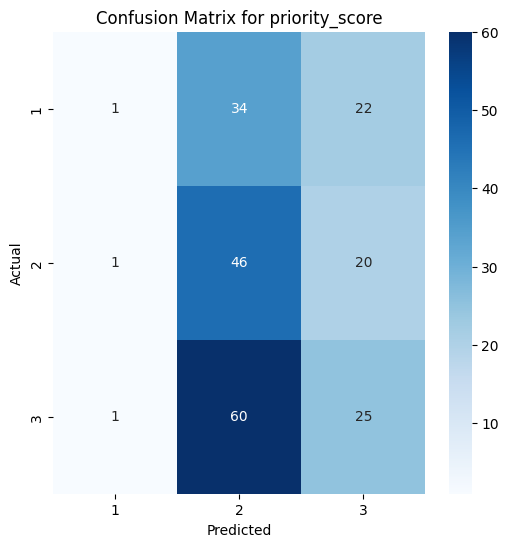

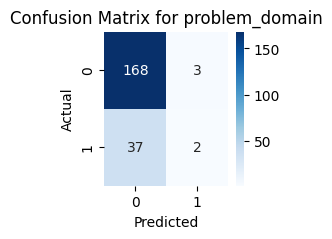

In [43]:
# Calculate confusion matrix for Label 1
cm1 = confusion_matrix(y_test1, y_pred1)

# Plot confusion matrix for Label 1
plot_confusion_matrix_3x3(cm1, title="Confusion Matrix for priority_score")

# Calculate confusion matrix for Label 2
cm2 = confusion_matrix(y_test2, y_pred2)

# Plot confusion matrix for Label 2
plot_confusion_matrix_2x2(cm2, title="Confusion Matrix for problem_domain")

In [45]:
# Map the top words to their corresponding labels for priority_score
top_words_map1 = {}
for i, label in enumerate(y_pred1):
    if label not in top_words_map1:
        top_words_map1[label] = []
    top_words_map1[label].append(sentences[i])

# Map the top words to their corresponding labels for problem_domain
top_words_map2 = {}
for i, label in enumerate(y_pred2):
    if label not in top_words_map2:
        top_words_map2[label] = []
    top_words_map2[label].append(sentences[i])

print("Top Words for Priority Score:")
for label, words in top_words_map1.items():
    print("Label", label, ":", words)

print("Top Words for Problem Domain:")
for label, words in top_words_map2.items():
    print("Label", label, ":", words)


Top Words for Priority Score:
Label 2 : ["Sorry, including the expensive price + apk using English for people who don't understand, it will be difficult to book", 'Setelah install terus pas buka aplikasi ngeblank putih', 'udah mahal , makanan ga enak, banyak lalat', 'fitur chat dengan host tidak bisa digunakan, padahal itu yg terpenting', 'Mahal mahal.. kirain LBH murah dari refdorz dan oyo', 'duh ini berisik amat yg diatas. Pake peredam dong podnya.', 'ribet pemesanan nya, pelayanan nya juga kurang bagus', 'Ribet', 'Tidak ad pertanggung jawaban atas ksalahan aplikasi dengan tgl yg pindah sendiri,playananan kurang ,membuat holiday menjadi bad dengan ad nya seperti ini', 'Makin kesini makin kesana harga bobobox, harga paling murahnya 300k yg single. Karuan nginep di hotel benernya sekalian', 'PELAYANANNYA JELEK BANGET BESTI, FASILITAS YG DI DAPET TIAP KAMAR BEDA2 PADAHAL HARGA SAMA', 'Mba² resepsionisnya judes.. untuk cabang bekasi', 'Kenapa tiba² logout dan gk bisa login lagi?', 'Maaf 